In [35]:
import numpy as np
import pandas as pd
import string, re
import matplotlib.pyplot as plt

import tensorflow as tf
import nltk

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [36]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

plt.rcParams['figure.figsize'] = (20, 8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data
**pandas.read_csv** function : load Data from *excel* files

In [37]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')
y_test = pd.read_csv('Dataset/submit.csv')

### Show Raw Data
Data before clean it and merge **title** and **text**

In [38]:
print(f"Train Shape : {train.shape}")
print(f"Test Shape : {test.shape}")
print(f"Submit Shape : {y_test.shape}")

Train Shape : (20800, 5)
Test Shape : (5200, 4)
Submit Shape : (5200, 2)


In [39]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [40]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


### Check Null Value in Data

In [41]:
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [42]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [43]:
train.dtypes.value_counts()
test.dtypes.value_counts()

object    3
int64     1
dtype: int64

### Fill Null Values

In [44]:
def fill_data(data):
    data["title"] = data["title"].fillna("No Title")
    data["text"] = data["text"].fillna("No text")
    return data

train = fill_data(train)
test = fill_data(test)

In [45]:
train.isnull().sum()

id           0
title        0
author    1957
text         0
label        0
dtype: int64

In [46]:
test.isnull().sum()

id          0
title       0
author    503
text        0
dtype: int64

### Merge & Drop
merge **title** and **text** sections </br> drop **author** and **id**

In [47]:
#Initializ y_train and x_train
train['text_merge'] = train['title'].astype(str) + " " + train['text'].astype(str)
x_train = train['text_merge']
y_train = train.drop(['id','title','author','text','text_merge'], axis = 1)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(20800,)
(20800, 1)


In [48]:
#Initializ y_test and x_test
test['text_merge'] = test['title'].astype(str) + " " + test['text'].astype(str)
x_test = test['text_merge']
y_test = y_test.drop(['id'], axis = 1)
y_test = np.array(y_test)

In [49]:
print(x_test.shape)
print(y_test.shape)

(5200,)
(5200, 1)


### Clean Data
**clean_input** is function that take the *string(text)*, remove **links** and **Punctuation** from it,<br> convert it to **lower case** and maintains **arabic and english** letters

In [50]:
#   text_to_clean = re.sub(r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', text_to_fuck)

url_pattern = re.compile(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')
number_pattern = re.compile(r'[0-9]+')
non_alpha_pattern = re.compile(r'[^a-zA-Z\u0621-\u064A\s]')
number_number_pattern = re.compile(r'numbernumber+')

def clean_input(text_to_clean):
    text_to_clean = text_to_clean.lower()
    text_to_clean = url_pattern.sub('', text_to_clean)
    text_to_clean = number_pattern.sub('', text_to_clean)
    text_to_clean = non_alpha_pattern.sub('', text_to_clean)
    text_to_clean = number_number_pattern.sub('number', text_to_clean)
    return text_to_clean

### Delete Stop Words
Delete **Arabic&English** stop words and **punctuation**

In [51]:
punc = list(string.punctuation)
stop_words = stopwords.words("english")
stop_words_2 = stopwords.words("arabic")


def processing_text(data):
    data = " ".join([word for word in word_tokenize(data)
                        if ((word not in stop_words) and (word not in stop_words_2) and (word not in punc))])

    return data

### Use Clean Data Methods

In [52]:
for i in range(x_train.shape[0]):
    x_train.values[i] = clean_input(x_train[i])
    x_train.values[i] = processing_text(x_train[i])

In [61]:
x_train.head()

0    house dem aide didnt even see comeys letter ja...
1    flynn hillary clinton big woman campus breitba...
2    truth might get fired truth might get fired oc...
3    civilians killed single us airstrike identifie...
4    iranian woman jailed fictional unpublished sto...
Name: text_merge, dtype: object

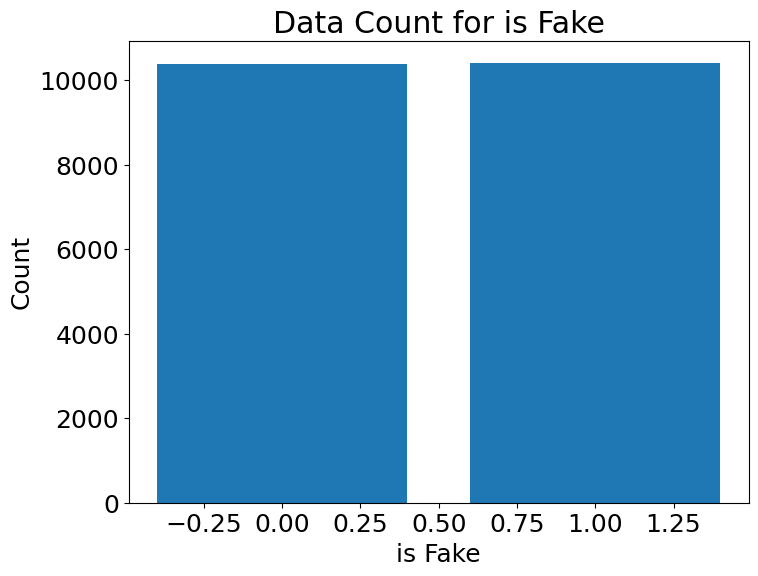

In [62]:
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(unique, counts)
plt.xlabel('is Fake')
plt.ylabel('Count')
plt.title('Data Count for is Fake')
plt.show()

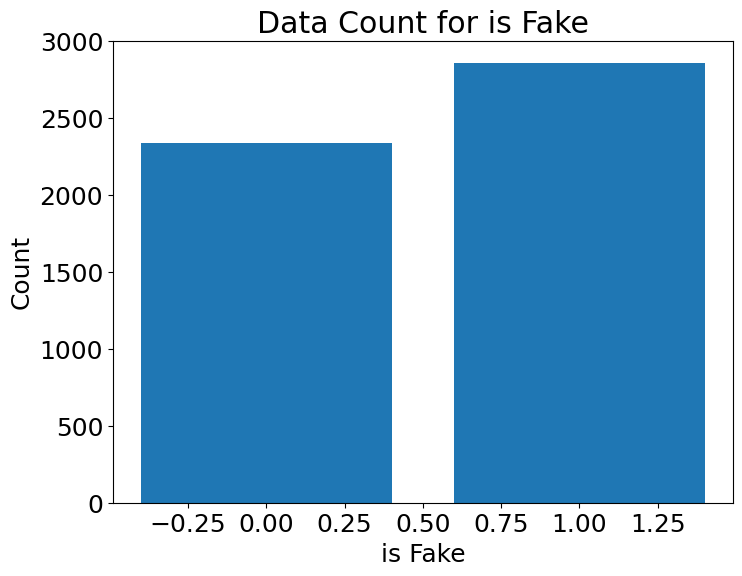

In [64]:
unique, counts = np.unique(y_test, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(unique, counts)
plt.xlabel('is Fake')
plt.ylabel('Count')
plt.title('Data Count for is Fake')
plt.show()

In [65]:
fake = x_train[y_train.flatten() == 1].tolist()
not_fake = x_train[y_train.flatten() == 0].tolist()

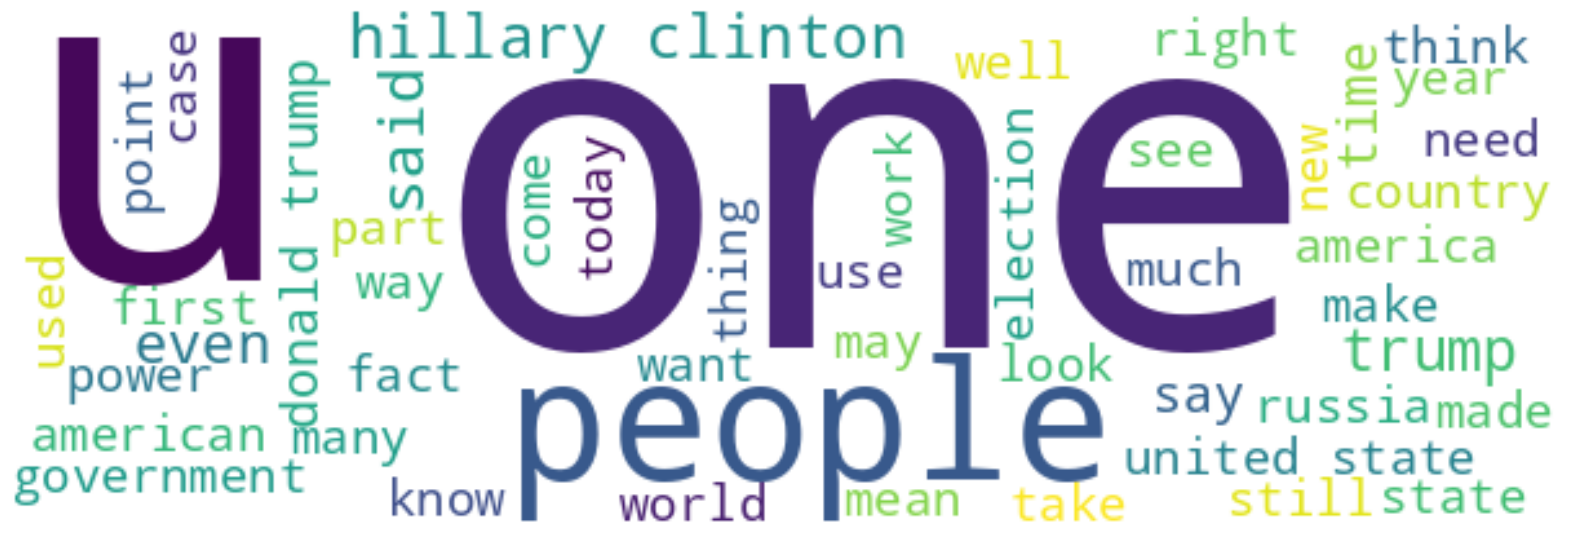

In [66]:
wordcloud = WordCloud(max_words = 50, width = 600, background_color = 'white').generate(" ".join(fake))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

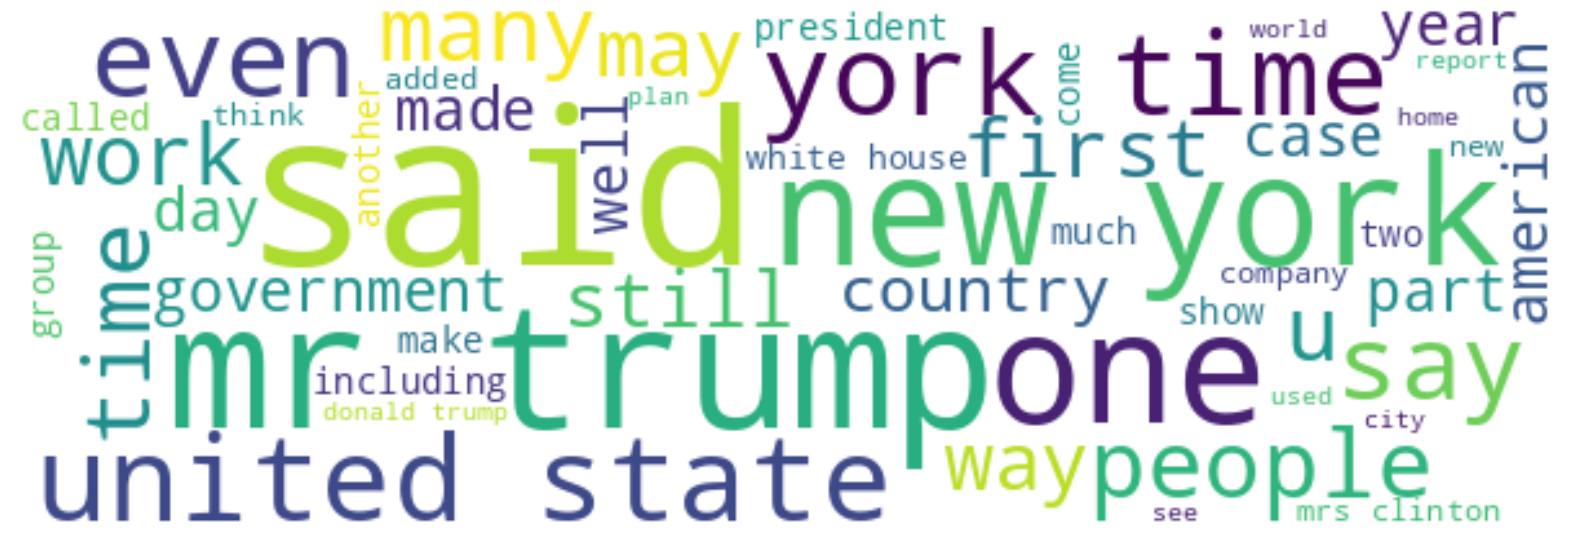

In [67]:
wordcloud = WordCloud(max_words = 50, width = 600, background_color = 'white').generate(" ".join(not_fake))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Not Fake text length')

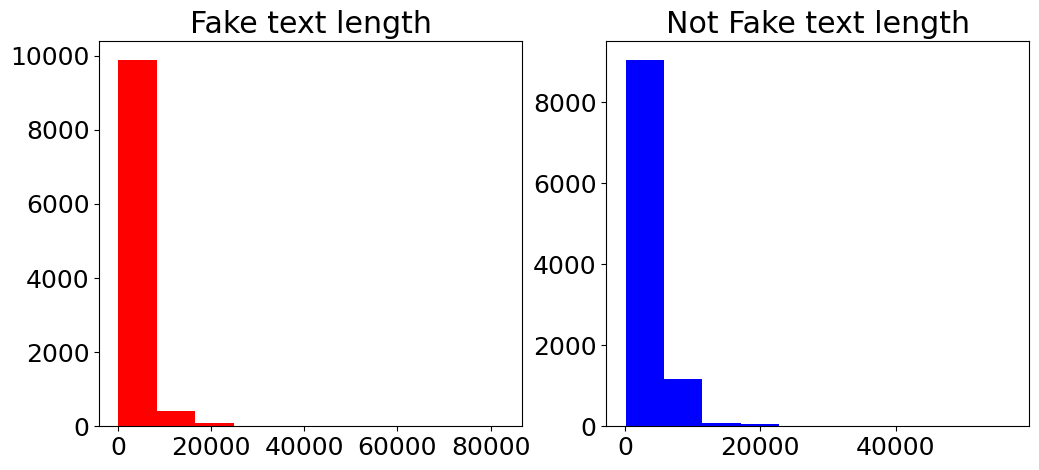

In [68]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

ax1.hist([len(x) for x in fake], color = 'red')
ax1.set_title('Fake text length')

ax2.hist([len(x) for x in not_fake], color = 'blue')
ax2.set_title('Not Fake text length')

Text(0.5, 1.0, 'Not Fake text word count')

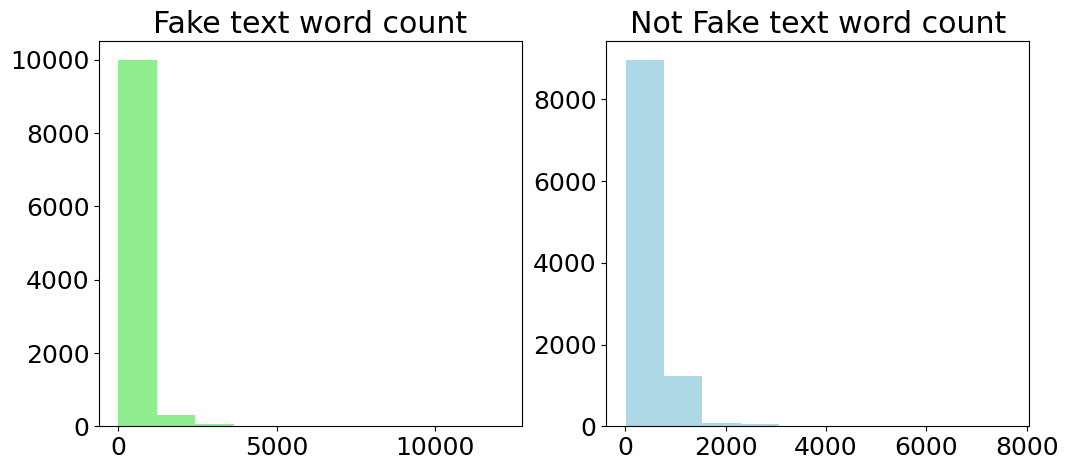

In [69]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
text_len = x_train[y_train.flatten() == 1].str.split().map(lambda x: len(x))
ax1.hist(text_len, color = 'lightgreen')
ax1.set_title('Fake text word count')

text_len = x_train[y_train.flatten() == 0].str.split().map(lambda x: len(x))
ax2.hist(text_len, color = 'lightblue')
ax2.set_title('Not Fake text word count')

### Tokenizer Section

In [70]:
number_words = 1000
maxlen = 4000
truncat = 'post'
padd = 'post'
token = '<OOV>'

tokenizer = Tokenizer(oov_token = token)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(sequences_train, maxlen = maxlen, truncating = truncat, padding = padd)

sequences_test = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(sequences_test, maxlen = maxlen, truncating = truncat, padding = padd)

### Normalize Data
Scale the tokenized data between **0** and **1**.

In [71]:
X_train_float = X_train.astype('float32')
X_test_float = X_test.astype('float32')

max_val = np.max([np.max(X_train_float), np.max(X_test_float)])
min_val = np.min([np.min(X_train_float), np.min(X_test_float)])

X_train_normalized = (X_train_float - min_val) / (max_val - min_val)
X_test_normalized = (X_test_float - min_val) / (max_val - min_val)

X_train_normalized = np.clip(X_train_normalized, 0, 1)
X_test_normalized = np.clip(X_test_normalized, 0, 1)

print(X_train_normalized.shape)
print(X_test_normalized.shape)

(20800, 4000)
(5200, 4000)


In [72]:
print(X_train.shape)
print(X_test.shape)

(20800, 4000)
(5200, 4000)
